In [2]:
import sys 
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, top_k_accuracy_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product

from torch.utils.data import DataLoader, TensorDataset

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import VariationalAutoencoder, Autoencoder

In [3]:
network_type = 'ba' # ba for Barabasi-Albert network, sw for small world network
df = pd.read_csv(r'../data/{}-network-100k_dataset.csv'.format(network_type), index_col=0)
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[[str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(round(df['beta'].min(), 2), 
                                                                  round(df['beta'].max(), 2),
                                                                  round(df['alpha'].min(), 2),
                                                                  round(df['alpha'].max(), 2)))

Диапазон параметров beta:[0.1, 0.99], alpha:[0.2, 0.99]


In [4]:
len(data.iloc[0,-1])

150

In [82]:

#X_train, X_val = train_test_split(X_train, test_size=1200, random_state=42, stratify=None)
#X_train = X_train.sort_values(by = ['seed_number'])
#X_val = X_val.sort_values(by = ['seed_number'])
#X_test = X_test.sort_values(by = ['seed_number'])

In [5]:
X = data.drop(columns=['ts'])#[['file']]
y = data['ts']

X_train, X_test = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
y_train = y.loc[X_train.index].values
y_test = y.loc[X_test.index].values

X_train, X_test = X_train.values, X_test.values

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)


In [6]:

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Autoencoder

In [7]:
def loss(criterion, pred, gt):
    loss = criterion(pred, gt)
    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

In [8]:
def train(
    model,
    n_epochs,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    patience=5,
    delta=0,
    device='cpu'
):
    best_loss = float('inf')
    counter = 0
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            loss = criterion(pred, y_batch.to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation on test/validation set
        model.eval()
        test_total_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                pred_test = model(X_test.to(device))
                loss_test = criterion(pred_test, y_test.to(device))
                test_total_loss += loss_test.item()

        avg_test_loss = test_total_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}, Train loss: {avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")

        if avg_test_loss < 3300:
            break

        # Early stopping logic
        # if avg_train_loss < best_loss - delta:
        #     best_loss = avg_train_loss
        #     counter = 0
        # else:
        #     counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break
    return train_losses, test_losses


#### Grid search for best hiddens_size and latent_size

In [12]:
from itertools import product

mse_cr = F.mse_loss
r2_cr = r2_loss

# Define grid ranges
hidden_sizes = [16, 32, 64, 128, 256]               # Example values; adjust as needed
latent_sizes = [16, 32, 64, 128, 256]                 # Example values; adjust as needed

results = []

# for hidden_size, latent_size in product(hidden_sizes, latent_sizes):
#     print(f"Testing hidden_size={hidden_size}, latent_size={latent_size}")
    
#     # Initialize new model for each combo
#     model = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    
#     # You must re-create your DataLoader objects if your data depends on model params
#     # train_loader, test_loader = ...
  
#     # Train model
#     train_losses, test_losses = train(
#         model=model,
#         n_epochs=50,   # reduce for faster search, or keep as n_epochs
#         train_loader=train_loader,
#         test_loader=test_loader,
#         criterion=mse_cr,
#         optimizer=optimizer,
#         scheduler=None,      # or your scheduler if needed
#         patience=5,
#         delta=0,
#         device=device
#     )
#     # Evaluate performance (last test loss, or min/avg as you wish)
#     best_test_loss = min(test_losses)
#     results.append({
#         'hidden_size': hidden_size,
#         'latent_size': latent_size,
#         'test_loss': best_test_loss
#     })

# # Find best combination
# best_config = min(results, key=lambda x: x['test_loss'])
# print("Best config:", best_config)

# # To display all results
# for res in results:
#     print(res)

#### AE train

In [59]:
hidden_size = 256
latent_size = 32
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
ae = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=5e-4)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

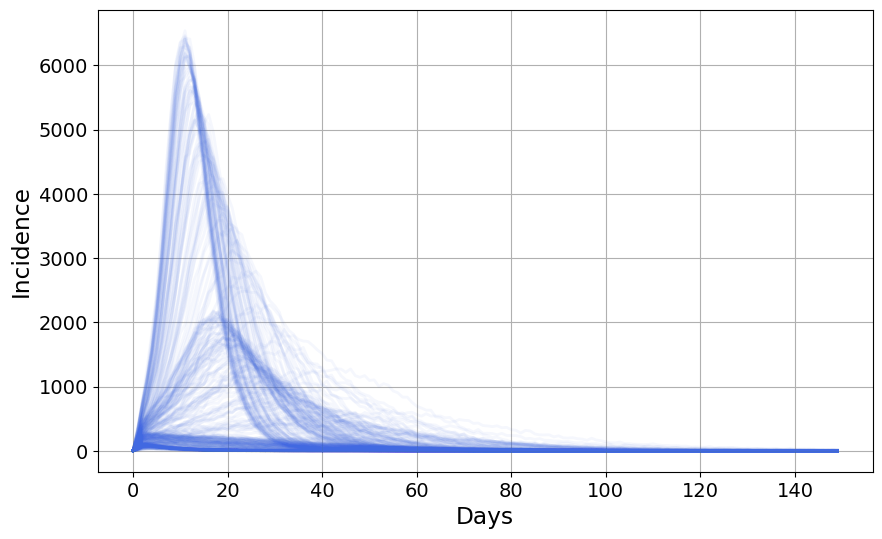

In [60]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(0, len(data), 20):
    ax.plot(data.values[i][2], lw='2', color='RoyalBlue', alpha=0.05)
ax.set_xlabel('Days', fontsize=1.2*fontsize)
ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.legend(fontsize=1.2*fontsize)
ax.grid()


In [61]:

train_losses, test_losses = train(model=ae,
        n_epochs=100,   # reduce for faster search, or keep as n_epochs
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=mse_cr,
        optimizer=optimizer,
        scheduler=None,      # or your scheduler if needed
        patience=5,
        delta=0,
        device=device)

Epoch 1, Train loss: 334870.7941, Test loss: 211316.3434
Epoch 2, Train loss: 125729.2480, Test loss: 63857.7135
Epoch 3, Train loss: 57383.4014, Test loss: 53662.0627
Epoch 4, Train loss: 40862.9927, Test loss: 46920.1576
Epoch 5, Train loss: 28867.2512, Test loss: 23696.2453
Epoch 6, Train loss: 22327.0522, Test loss: 35403.8808
Epoch 7, Train loss: 19122.5215, Test loss: 15985.7078
Epoch 8, Train loss: 16997.4678, Test loss: 15513.4507
Epoch 9, Train loss: 14466.8141, Test loss: 12805.7693
Epoch 10, Train loss: 12977.3054, Test loss: 16844.2799
Epoch 11, Train loss: 10736.5309, Test loss: 10332.9227
Epoch 12, Train loss: 9147.0254, Test loss: 16193.6681
Epoch 13, Train loss: 9691.8399, Test loss: 8706.1892
Epoch 14, Train loss: 7012.2633, Test loss: 7403.2096
Epoch 15, Train loss: 6863.4965, Test loss: 5846.6487
Epoch 16, Train loss: 6518.8006, Test loss: 6093.8143
Epoch 17, Train loss: 6462.5137, Test loss: 6114.0722
Epoch 18, Train loss: 6831.8466, Test loss: 5325.9583
Epoch 19, T

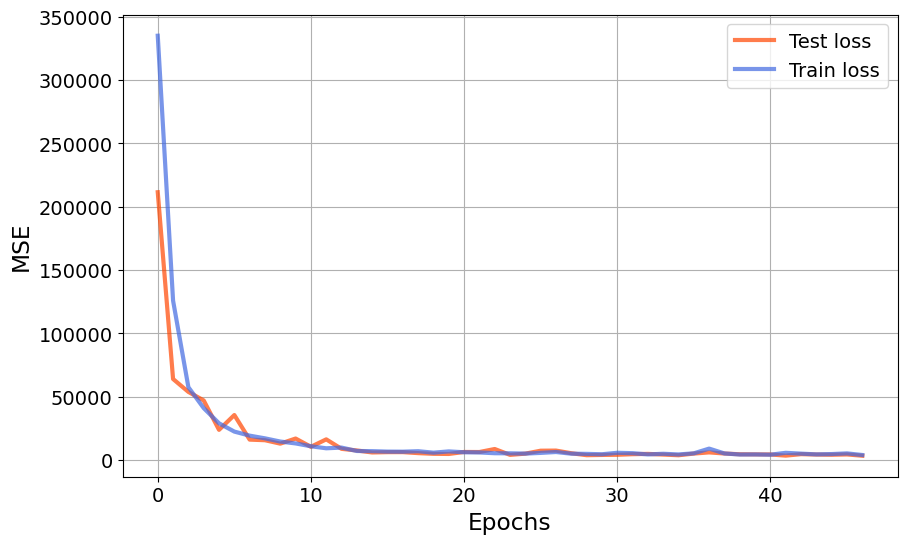

In [62]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_losses, lw=3, label='Test loss', color='OrangeRed', alpha=0.7)
ax.plot(train_losses, lw=3, label='Train loss', color='RoyalBlue', alpha=0.7)
ax.set_xlabel('Epochs', fontsize=1.2*fontsize)
ax.set_ylabel('MSE', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid()
fig.savefig(r'../figures/ae_{}_network_loss_epochs_n.png'.format(network_type), 
            dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_loss_epochs_n.pdf'.format(network_type), 
            bbox_inches='tight')


In [63]:
test(ae, X_test, y_test)

R2 Score: 0.8911571735640367


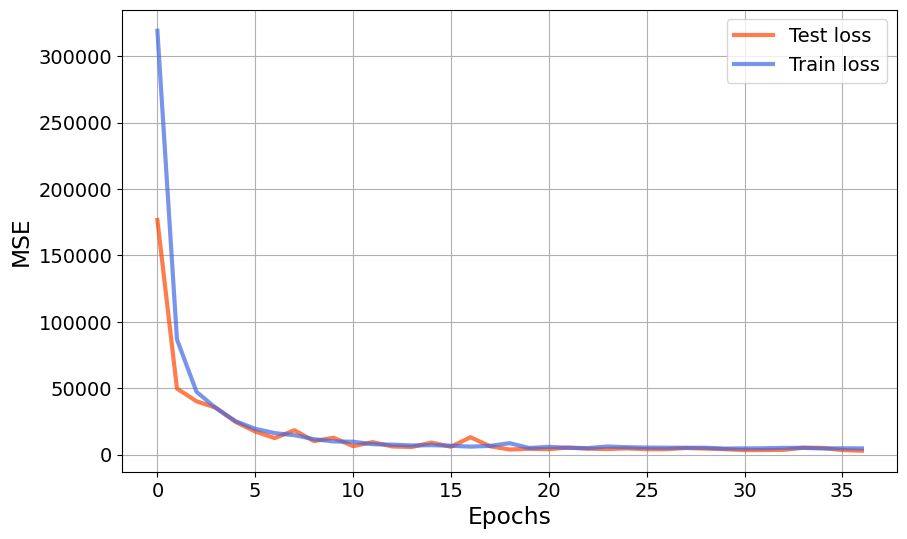

In [ ]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_losses, lw=3, label='Test loss', color='OrangeRed', alpha=0.7)
ax.plot(train_losses, lw=3, label='Train loss', color='RoyalBlue', alpha=0.7)
ax.set_xlabel('Epochs', fontsize=1.2*fontsize)
ax.set_ylabel('MSE', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid()
fig.savefig(r'../figures/ae_{}_network_loss_epochs_n.png'.format(network_type), 
            dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_loss_epochs_n.pdf'.format(network_type), 
            bbox_inches='tight')


In [31]:
test(ae, X_test, y_test)

R2 Score: -2092236.2982579533


In [64]:
torch.save(ae, '../models/autoencoder_barabasi_100k_n.pt')

#### AE save/load model

In [9]:
# Saving
# torch.save(ae, '../models/autoencoder.pt')

# Loading
ae = torch.load('../models/autoencoder_barabasi_100k_n.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=150, bias=True)
  )
)

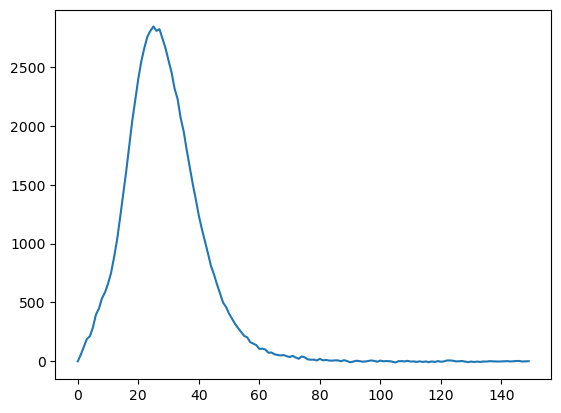

In [11]:
plt.plot(ae(torch.tensor([0.1, 0.95])).detach().numpy())

In [12]:
test_indices = [11,7,1,15]
for elem in test_indices:
    print(X_test[elem])

[0.35 0.44]
[0.4  0.59]
[0.41 0.71]
[0.37 0.75]


In [13]:
network_type = 'ba' # ba for Barabasi-Albert network, sw for small world network
df = pd.read_csv(r'../data/{}-network-100k_dataset.csv'.format(network_type), index_col=0)
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[[str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]



X = data.drop(columns=['ts'])#[['file']]
y = data['ts']

X_train, X_test = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
y_train = y.loc[X_train.index].values
y_test = y.loc[X_test.index].values

X_train, X_test = X_train.values, X_test.values

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)


#### AE subplots

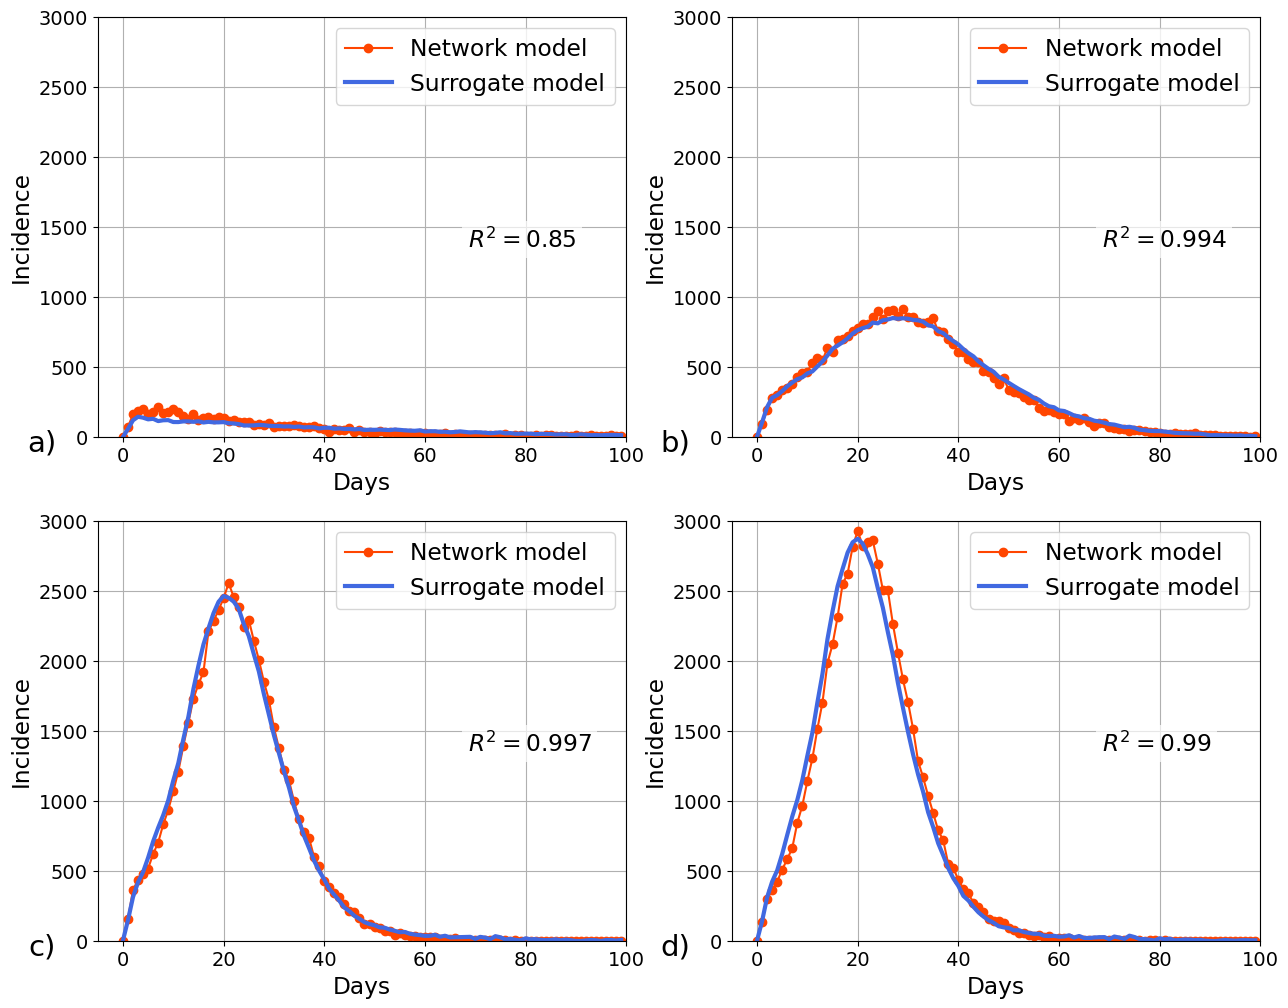

In [17]:
fontsize = 14
test_indices = [11,7,1,15]
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))

labels = ['a)', 'b)', 'c)', 'd)']
counter = 0
cut = 100
for row in range(rows):
    for col in range(cols):
        surrogate_sim = predict(ae, X_test[test_indices[counter]]).numpy()
        r2 = r2_score(y_test[test_indices[counter]], surrogate_sim)
        
        ax[row][col].plot(y_test[test_indices[counter]][:cut], label='Network model', marker='o', color='OrangeRed')
        ax[row][col].plot(surrogate_sim[:cut], lw=3, color='RoyalBlue', label='Surrogate model')

        ax[row][col].set_xlabel('Days', fontsize=1.2*fontsize)
        ax[row][col].set_ylabel('Incidence', fontsize=1.2*fontsize)
        ax[row][col].set_ylim(0, 3000)
        ax[row][col].set_xlim(-5, 100)
        ax[row][col].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[row][col].legend(fontsize=1.2*fontsize)
        ax[row][col].grid()
        # ax[row][col].set_title(r'$R^2={}$'.format(round(r2, 3)), fontsize=1.2*fontsize)
        
        # Add subplot label outside the top-left corner
        ax[row][col].annotate(labels[counter], xy=(0, 0), xycoords='axes fraction',
                              xytext=(-30, -10), textcoords='offset points',
                              fontsize=1.5*fontsize, ha='right', va='baseline')
        ax[row][col].text(0.7, 0.5, r'$R^2={}$'.format(round(r2, 3)), transform=ax[row][col].transAxes,
                          fontsize=1.2*fontsize, verticalalignment='top',
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        counter += 1


fig.savefig(r'ae_{}_network_subplots_point_estimation_n.pdf'.format(network_type), bbox_inches='tight')
fig.savefig(r'ae_{}_network_subplots_point_estimation_n.png'.format(network_type), dpi=600, bbox_inches='tight')


#### AE Colormap

In [123]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

In [16]:
import time

val = 0
for index in range(1000):
    start = time.time()
    predict(ae, X_test[index])
    end = time.time()
    val += end - start
print(val/1000)

0.00016816353797912596


In [124]:
np.mean(R2_test)

np.float64(0.8897865538050731)

In [17]:
np.mean(R2_test)

0.8745296797977034

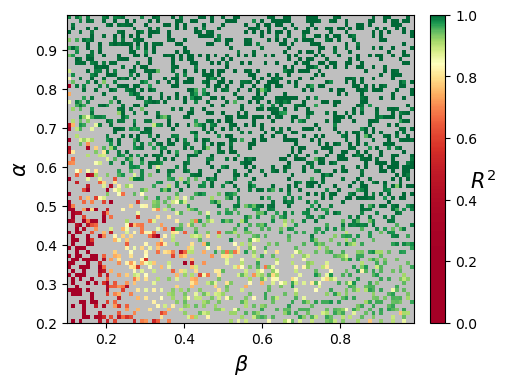

In [125]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**4

# Get plasma colormap and create nonlinear version
plasma = plt.cm.RdYlGn
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
nonlinear_cmap.set_bad('gray', alpha=0.5)  # train in gray
img = ax.imshow(masked_heatmap, origin='lower', 
                cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], 
                         param_1_vals[-1], param_2_vals[0], param_2_vals[-1]],
                 aspect='equal')
fontsize=10
cbar = fig.colorbar(img, ax=ax, label='$R^2$', fraction=0.04, pad=0.04)
cbar.ax.yaxis.label.set_size(1.5*fontsize)  # colorbar label fontsize
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.tick_params(labelsize=1.*fontsize)    # colorbar tick labels fontsize
ax.set_xlabel(r'$\beta$', fontsize=1.5*fontsize)
ax.set_ylabel(r'$\alpha$', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=1.*fontsize)
# ax.set_title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')

fig.savefig(r'../figures/ae_{}_network_colormap_point_estimation_n.png'.format(network_type), dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_colormap_point_estimation_n.pdf'.format(network_type), bbox_inches='tight')

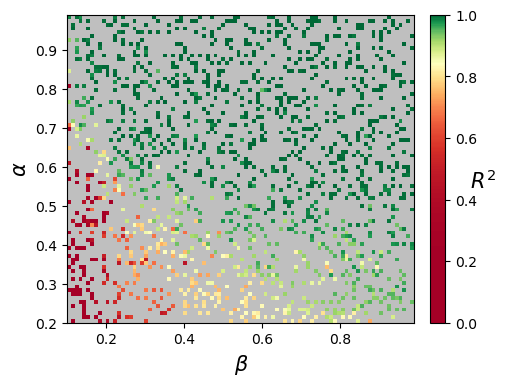

In [22]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**4

# Get plasma colormap and create nonlinear version
plasma = plt.cm.RdYlGn
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
nonlinear_cmap.set_bad('gray', alpha=0.5)  # train in gray
img = ax.imshow(masked_heatmap, origin='lower', 
                cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], 
                         param_1_vals[-1], param_2_vals[0], param_2_vals[-1]],
                 aspect='equal')
fontsize=10
cbar = fig.colorbar(img, ax=ax, label='$R^2$', fraction=0.04, pad=0.04)
cbar.ax.yaxis.label.set_size(1.5*fontsize)  # colorbar label fontsize
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.tick_params(labelsize=1.*fontsize)    # colorbar tick labels fontsize
ax.set_xlabel(r'$\beta$', fontsize=1.5*fontsize)
ax.set_ylabel(r'$\alpha$', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=1.*fontsize)
# ax.set_title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')

fig.savefig(r'../figures/ae_{}_network_colormap_point_estimation.png'.format(network_type), dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_colormap_point_estimation.pdf'.format(network_type), bbox_inches='tight')

In [126]:
import seaborn as sns


In [1]:
heatmap.shape

NameError: name 'heatmap' is not defined

In [2]:
param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]

NameError: name 'param_1_vals' is not defined

In [129]:
dd = pd.DataFrame(heatmap)
dd.columns = np.arange(0.1, 1., 0.01).round(2)
dd.index = np.arange(0.2, 1., 0.01).round(2)
dd.sort_index(level=1, ascending=False)

,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0.99,0.981983,NaN,0.988724,0.966216,NaN,0.985487,NaN,NaN,NaN,0.985373,...,NaN,NaN,0.996251,0.999199,NaN,NaN,NaN,NaN,0.998011,NaN
0.98,NaN,NaN,NaN,0.981025,NaN,0.994929,0.990332,NaN,NaN,0.994649,...,NaN,NaN,0.999209,NaN,0.998953,0.999175,NaN,0.999600,0.998724,NaN
0.97,NaN,0.992058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.999160,0.998335,0.998209,NaN,NaN,NaN
0.96,NaN,0.997015,NaN,NaN,NaN,0.997150,NaN,0.997590,NaN,NaN,...,0.999668,NaN,0.999473,NaN,NaN,0.998163,NaN,0.999640,NaN,NaN
0.95,0.997113,NaN,NaN,0.991936,NaN,NaN,0.989792,NaN,NaN,NaN,...,NaN,0.999749,NaN,0.999334,NaN,NaN,NaN,0.998690,NaN,0.999596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.24,NaN,-0.905215,NaN,NaN,-1.372599,NaN,NaN,0.468842,NaN,0.386724,...,NaN,NaN,NaN,0.946692,0.962270,NaN,NaN,NaN,NaN,NaN
0.23,NaN,NaN,NaN,NaN,-0.713689,NaN,NaN,NaN,NaN,NaN,...,NaN,0.961258,NaN,0.965877,0.950998,0.937316,NaN,0.962214,NaN,NaN
0.22,NaN,NaN,NaN,NaN,-0.831288,NaN,NaN,NaN,0.449037,NaN,...,NaN,0.959589,NaN,NaN,NaN,NaN,0.765301,0.912953,0.909610,NaN
0.21,NaN,NaN,NaN,NaN,-0.548798,-0.020589,NaN,0.344408,0.392576,0.529370,...,NaN,NaN,NaN,NaN,0.894455,NaN,NaN,0.945303,NaN,NaN


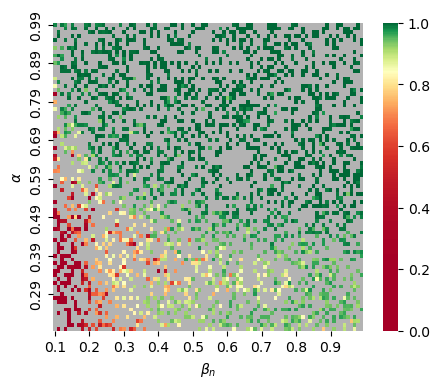

In [130]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax_i = ax
cmap = nonlinear_cmap
sns.heatmap(dd.sort_index(level=1, ascending=False), 
            yticklabels = 10, xticklabels=10,
            vmin=0, vmax=1,
            #vmax=40, 
            cmap=cmap,
            ax=ax_i, linewidths=0.0, rasterized=True)

ax_i.collections[0].cmap.set_bad('0.7')
ax_i.set_xlabel(r'$\beta_n$')
ax_i.set_ylabel(r'$\alpha$')
cbar = ax_i.collections[0].colorbar

In [131]:
def plot_test_with_intervals(params, gt, fontsize=14):
    gt = np.array(gt)
    mean_index = range(tmax)
    low_index = range(tmax, 2*tmax)
    high_index = range(2*tmax, 3*tmax)
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt[mean_index], label='Network model', marker='o', color='OrangeRed')
    ax.fill_between(np.linspace(0, tmax, tmax), gt[low_index], gt[high_index],
                    alpha = 0.5, color='OrangeRed', label='Network model interval')
    ax.plot(surrogate_sim[mean_index], lw=3, color='RoyalBlue', label='Surrogate model')
    ax.fill_between(np.linspace(0, tmax, tmax), 
                    surrogate_sim[low_index], 
                    surrogate_sim[high_index],
                    alpha = 0.5, color='RoyalBlue', label='Surrogate model interval')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def interval_ae_loss(pred, target, theta_1=1.0, theta_2=1.0, theta_3=1.0):
    """
    Custom loss for interval-aware autoencoder.
    """
    # Split the prediction into mean, lower bound, upper bound
    mean_pred, lb_pred, ub_pred = torch.chunk(pred, 3, dim=1)

    # Squeeze last dimension if needed
    mean_pred = mean_pred.squeeze(-1)
    # print(mean_pred.size())
    lb_pred = lb_pred.squeeze(-1)
    ub_pred = ub_pred.squeeze(-1)
    # Ensure target shape matches
    target = target.squeeze(-1) if target.ndim == 2 else target

    # print(target.size())

    # Mean squared error for the mean prediction
    mean_loss = torch.nn.functional.mse_loss(pred, target)

    # Bound loss
    bound_loss = torch.mean(torch.relu(lb_pred - mean_pred) + torch.relu(mean_pred - ub_pred))

    # Interval constraint loss
    interval_loss = torch.mean(torch.relu(lb_pred - ub_pred))

    total_loss = theta_1 * mean_loss + theta_2 * bound_loss + theta_3 * interval_loss
    return total_loss


In [132]:
# Saving 
# torch.save(ae, '../models/autoencoder_interval_barabasi_100k.pt')

# Loading
ae = torch.load('../models/autoencoder_interval_barabasi_100k_n.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=450, bias=True)
  )
)

In [133]:
df = pd.read_csv('../data/network_model_interval_dataset_7200.csv', index_col=0)
network_type = 'ba'
tmax = int((df.values.shape[1] - 5)/3) # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[['incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['low_incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['high_incidence_' + str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]

'''
X_train, X_test, y_train, y_test =  train_test_split(data.drop(columns=['ts']), 
                                                     data.ts.values, 
                                                     test_size=0.2, 
                                                     random_state=42)
X_train, X_test = X_train.values, X_test.values
'''

X = data.drop(columns=['ts'])#[['file']]
y = data['ts']

X_train, X_test = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
y_train = y.loc[X_train.index].values
y_test = y.loc[X_test.index].values

X_train, X_test = X_train.values, X_test.values

In [134]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))
np.mean(R2_test)

np.float64(0.9649548299610615)

In [139]:
dd2 = pd.DataFrame(heatmap2)
dd2.columns = np.arange(0.1, 1., 0.01).round(2)
dd2.index = np.arange(0.2, 1., 0.01).round(2)
dd2.sort_index(level=1, ascending=False)

,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0.99,0.998100,NaN,0.997485,0.999142,NaN,0.996085,NaN,NaN,NaN,0.999698,...,NaN,NaN,0.999569,0.999380,NaN,NaN,NaN,NaN,0.997652,NaN
0.98,NaN,NaN,NaN,0.993089,NaN,0.990089,0.990510,NaN,NaN,0.997721,...,NaN,NaN,0.999597,NaN,0.999555,0.999517,NaN,0.999078,0.999598,NaN
0.97,NaN,0.990040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.999612,0.999786,0.999364,NaN,NaN,NaN
0.96,NaN,0.986713,NaN,NaN,NaN,0.997637,NaN,0.993727,NaN,NaN,...,0.999591,NaN,0.999589,NaN,NaN,0.999708,NaN,0.999776,NaN,NaN
0.95,0.971924,NaN,NaN,0.989837,NaN,NaN,0.993751,NaN,NaN,NaN,...,NaN,0.999567,NaN,0.998208,NaN,NaN,NaN,0.999845,NaN,0.999815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.24,NaN,0.666122,NaN,NaN,0.862374,NaN,NaN,0.807274,NaN,0.767495,...,NaN,NaN,NaN,0.935477,0.912047,NaN,NaN,NaN,NaN,NaN
0.23,NaN,NaN,NaN,NaN,0.846393,NaN,NaN,NaN,NaN,NaN,...,NaN,0.874339,NaN,0.915096,0.892179,0.896965,NaN,0.904678,NaN,NaN
0.22,NaN,NaN,NaN,NaN,0.819508,NaN,NaN,NaN,0.793305,NaN,...,NaN,0.893881,NaN,NaN,NaN,NaN,0.862619,0.857145,0.872000,NaN
0.21,NaN,NaN,NaN,NaN,0.823361,0.801099,NaN,0.815072,0.744649,0.758126,...,NaN,NaN,NaN,NaN,0.845750,NaN,NaN,0.808170,NaN,NaN


In [77]:
import seaborn as sns

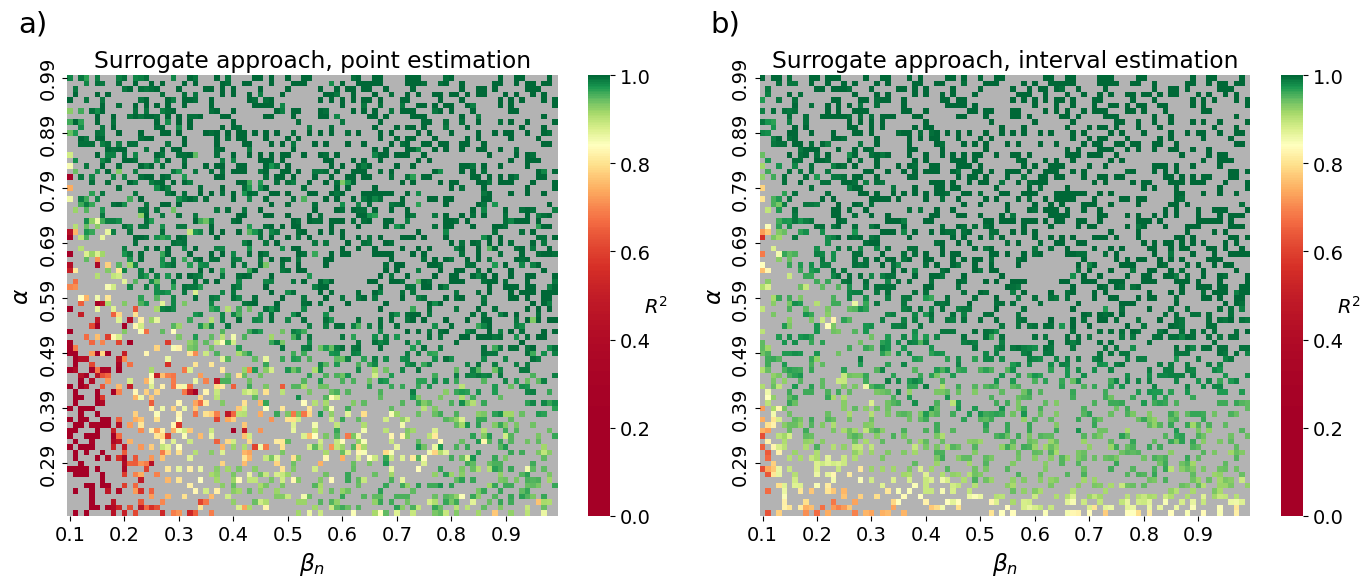

In [140]:
fontsize = 14
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flatten()

n = ['a)','b)'][::-1]


cmap = nonlinear_cmap


ax_1 = sns.heatmap(dd.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[0], #norm=norm, 
                   cbar_kws={'extendfrac': .1,
                            #"ticks":ticks, "boundaries":boundaries
                            },
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_1.set_title('Surrogate approach, point estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_1.collections[0].colorbar

ax_2 = sns.heatmap(dd2.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[1], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_2.set_title('Surrogate approach, interval estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_2.collections[0].colorbar


for ax_i in [ax_1, ax_2]:
    ax_i.text(-0.1, 1.1, n.pop(),
              transform=ax_i.transAxes, size=1.5*fontsize)
    ax_i.collections[0].cmap.set_bad('0.7')
    ax_i.set_xlabel(r'$\beta_n$', fontsize=1.2*fontsize)
    ax_i.set_ylabel(r'$\alpha$', fontsize=1.2*fontsize)
    ax_i.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = ax_i.collections[0].colorbar
    cbar.set_label(r'$R^2$', rotation=0, size=fontsize)
        
for i in [-1,-2]:    
    ax_1.figure.axes[i].tick_params(labelsize=fontsize)

#ax_1.figure.axes[-1].set_ylabel(r'$R^2$', size=fontsize)
#ax_1.figure.axes[-2].set_ylabel(r'$R^2$', size=fontsize)

plt.tight_layout()
fig.savefig(r'../figures/ae_colormap_n.png', dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_colormap_n.pdf', dpi=600, bbox_inches='tight')

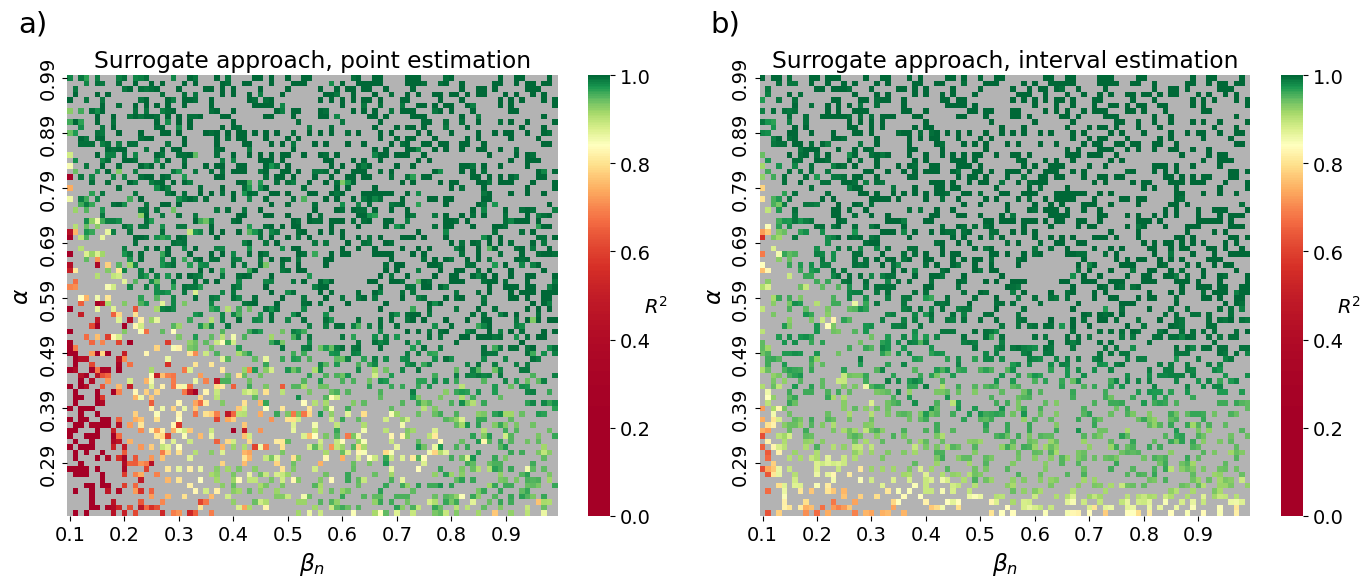

In [141]:
fontsize = 14
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flatten()

n = ['a)','b)'][::-1]


cmap = nonlinear_cmap


ax_1 = sns.heatmap(dd.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[0], #norm=norm, 
                   cbar_kws={'extendfrac': .1,
                            #"ticks":ticks, "boundaries":boundaries
                            },
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_1.set_title('Surrogate approach, point estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_1.collections[0].colorbar

ax_2 = sns.heatmap(dd2.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[1], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_2.set_title('Surrogate approach, interval estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_2.collections[0].colorbar


for ax_i in [ax_1, ax_2]:
    ax_i.text(-0.1, 1.1, n.pop(),
              transform=ax_i.transAxes, size=1.5*fontsize)
    ax_i.collections[0].cmap.set_bad('0.7')
    ax_i.set_xlabel(r'$\beta_n$', fontsize=1.2*fontsize)
    ax_i.set_ylabel(r'$\alpha$', fontsize=1.2*fontsize)
    ax_i.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = ax_i.collections[0].colorbar
    cbar.set_label(r'$R^2$', rotation=0, size=fontsize)
        
for i in [-1,-2]:    
    ax_1.figure.axes[i].tick_params(labelsize=fontsize)

#ax_1.figure.axes[-1].set_ylabel(r'$R^2$', size=fontsize)
#ax_1.figure.axes[-2].set_ylabel(r'$R^2$', size=fontsize)

plt.tight_layout()
fig.savefig(r'../figures/ae_colormap_n.png', dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_colormap_n.pdf', dpi=600, bbox_inches='tight')

In [137]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap2 = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap2[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap2, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True


fig.savefig(r'../figures/ae_{}_network_colormap_interval_estimation_n.png'.format(network_type), 
            dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_colormap_interval_estimation_n.pdf'.format(network_type), 
            bbox_inches='tight')

In [19]:
batch = next(iter(train_loader))
print(batch[0].size())
yhat = ae(batch[0])

torch.Size([16, 2])


In [31]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    # ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.set_ylim(0, 1500)
    ax.set_xlim(-5, 150)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    # ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

In [21]:
for _ in range(len(y_test)):
    index = random.randint(0, len(y_test))
    index = _
    if abs(X_test[index][0] - 0.7) < 0.1 and \
        abs(X_test[index][1] - 0.8) < 0.1 and max(y_test[index]) < 1500:
        fig = plot_test(X_test[index], y_test[index])
        fig.savefig(r'network_ba_simulation_{}.png'.format(index), 
                    dpi=600, bbox_inches='tight')
        fig.savefig(r'network_ba_simulation_{}.pdf'.format(index), 
                    bbox_inches='tight')
        print(X_test[index])
        print(index)
        break

In [22]:
for index in [26, 19, 511]:
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'network_ba_simulation_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')
    fig.savefig(r'network_ba_simulation_{}.pdf'.format(index), 
                bbox_inches='tight')
    print(X_test[index])

NameError: name 'vae' is not defined

### Variational autoencoder

In [23]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

def warmup_loss(epoch, n_epochs, criterion, steps, pred, mu, logvar, gt, use=True):
    if use:
        if epoch/n_epochs < steps:
            loss = criterion(pred ,gt)
        else:
            mse_loss = criterion(pred, gt)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse_loss + kl_loss
    else:
        loss = criterion(pred, gt)

    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred, _, _ = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    tb = SummaryWriter()

    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred, mu, logvar = model(X_batch.to(device))

            loss = warmup_loss(epoch, n_epochs, criterion, 0, pred, mu, logvar, y_batch.to(device), use=True)

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        tb.add_scalar("Total loss", loss.item(), epoch)
    tb.close()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
hidden_size = 512
latent_size = 256
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
vae = VariationalAutoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=5e-4)

In [27]:
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [28]:
train(vae, n_epochs, train_loader, mse_cr, optimizer, lr_sched)

100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


In [29]:
test(vae, X_test, y_test)

R2 Score: 0.8851743287560514


In [19]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(vae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

In [20]:
for _ in range(30):
    index = random.randint(0, len(y_test))
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'surrogate_network_model_comparison_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')

NameError: name 'vae' is not defined

In [21]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(vae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

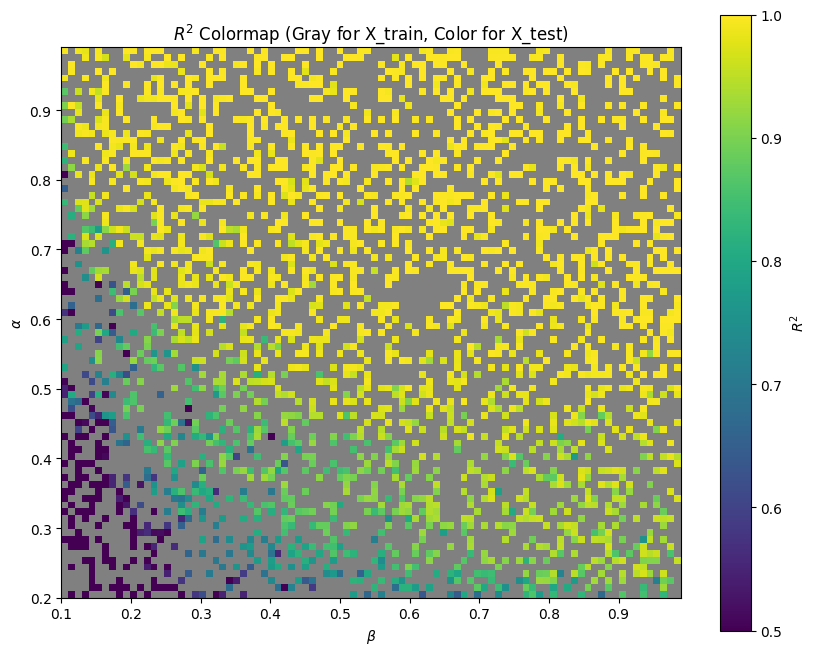

In [22]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis.copy()
cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=cmap, vmin=0.5, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')

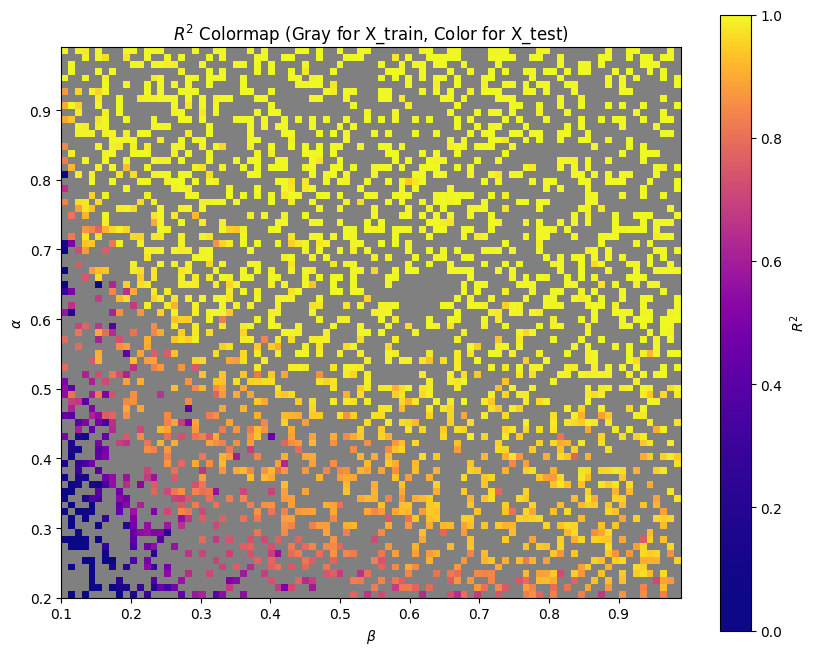

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**2

# Get plasma colormap and create nonlinear version
plasma = plt.cm.plasma
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
plt.figure(figsize=(10, 8))
nonlinear_cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')